In [329]:
"""Author: Fadi Farook

This code contains a lot of code that is provided in the analysis example provided : odr_fit_to_data.py 
from https://www.physics.utoronto.ca/apl/python/index.htm#repository.

"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
import scipy.odr

In [330]:
def gaussian_function(p, x):

    y_u = p[0]
    mean = p[1]
    sigma = p[2]
    temp = (x-mean)**2 / (2 * sigma**2)
    return y_u * np.exp(-temp)


def lognormal_function(p, x):

    y_u = p[0]
    mean = p[1]
    sigma = p[2]    
    temp = np.power((np.log(x) - mean), 2) / (2 * sigma**2)
    temp2 = y_u / (x * sigma)
    return temp2 * np.exp(-temp)


def laplacian_function(p, x):

    y_u = p[0]
    mean = p[1]
    sigma = p[2]
    temp = np.abs(x-mean) / (sigma)
    return y_u * np.exp(-temp) 

In [331]:
x1, x2, x3, y1, y2, y3, scale = np.loadtxt("Data Analysis Measurements.csv", delimiter=',', usecols=(1, 2, 3, 4, 5, 6, 7), unpack=True)


calibration_measured = 1.966666667
calibration_value = 26/calibration_measured

x_original = np.mean([x1, x2, x3], axis=0)
y_original = np.mean([y1, y2, y3], axis=0)

In [332]:
# Uncertainities
reading_uncertainty = 0.05  # cm
propagated_reading_uncertainity = np.sqrt(3*(0.05**2)) / 3  # since the mean is also divided by 3

systematic_uncertainty = propagated_reading_uncertainity  # also 3 measurements with same uncertainity

x = x_original * scale * calibration_value
y = y_original * scale * calibration_value

ux = x * np.sqrt((propagated_reading_uncertainity/x_original)**2 + (systematic_uncertainty/calibration_measured)**2)
uy = y * np.sqrt((propagated_reading_uncertainity/y_original)**2 + (systematic_uncertainty/calibration_measured)**2)

In [333]:
# Gaussian and Laplacian guesses
p_guess_1 = [110, 15, 2]

# Lognormal guess
p_guess_2 = [110, 3.1, 0.05]

func = laplacian_function  # change p_guess

if func == lognormal_function:
    p_guess = p_guess_2
    function_name = "Lognormal"
elif func == gaussian_function:
    p_guess = p_guess_1
    function_name = "Gaussian"
else:
    p_guess = p_guess_1
    function_name = "Laplacian"

In [334]:
# Load data for ODR fit
data = scipy.odr.RealData(x=x, y=y, sx=ux, sy=uy)
# Load model for ODR fit
model = scipy.odr.Model(func)

## Now fit model to data
#	job=10 selects central finite differences instead of forward
#       differences when doing numerical differentiation of function
#	maxit is maximum number of iterations
fitted = scipy.odr.ODR(data, model, beta0=p_guess, maxit=5000,job=10)

output = fitted.run()
p   = output.beta      # 'beta' is an array of the parameter estimates

print(p)

quasi_chisq = output.res_var
uncertainty = output.sd_beta # parameter standard uncertainties
print(uncertainty)

# if quasi_chisq < 1.0 :
#     uncertainty = uncertainty/np.sqrt(quasi_chisq)



# number of degrees of freedom
dof = len(x) - len(p_guess)

# Calculate initial residuals and adjusted error 'sigma_odr'
delta   = output.delta   # estimated x-component of the residuals
epsilon = output.eps     # estimated y-component of the residuals
# (dx_star,dy_star) are the projections of x_sigma and y_sigma onto the residual line
dx_star = ( ux*np.sqrt( ((uy*delta)**2) /
                ( (uy*delta)**2 + (ux*epsilon)**2 ) ) )
dy_star = ( uy*np.sqrt( ((ux*epsilon)**2) /
                ( (uy*delta)**2 + (ux*epsilon)**2 ) ) )
sigma_odr = np.sqrt(dx_star**2 + dy_star**2)
# residual is positive if the point lies above the fitted curve, negative if below
residual = ( np.sign(y-func(p,x))
              * np.sqrt(delta**2 + epsilon**2) )


[113.75214163  21.12025008   8.48408277]
[17.61290711  0.75646256  1.41316877]


In [335]:
chi2 = quasi_chisq
cdf = 100.*float(scipy.special.chdtrc(dof,dof*quasi_chisq))
print(("\nQuasi Chi-Squared/dof   = {0:10.5f}," +
                            " Chi-Squared CDF = {1:10.5f}%").
       format(chi2,cdf))   # important


Quasi Chi-Squared/dof   =   12.08220, Chi-Squared CDF =    0.00000%


<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_45610/1069843436.py:11: SyntaxWarning: invalid escape sequence '\c'
  ax1.annotate('$\chi^2$ = '+str(np.round(x2, 2)), (80, 10))
/tmp/ipykernel_45610/1069843436.py:15: S

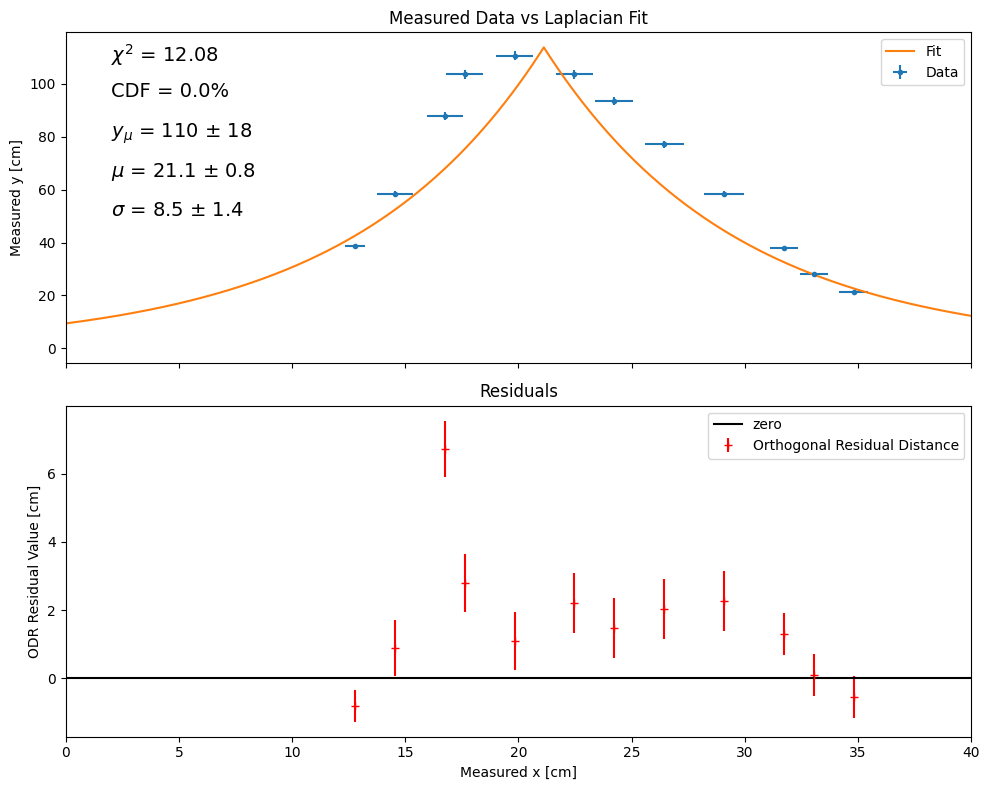

In [336]:
"""Plotting """

continuous_x = np.linspace(0, 100, 1000)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))  # Two subplots, sharing the x-axis

# Plot Data and Fit on ax1
ax1.set_title(f"Measured Data vs {function_name} Fit")
ax1.errorbar(x, y, yerr=uy, xerr=ux, fmt='.', label='Data')
ax1.plot(continuous_x, func(p, continuous_x), label='Fit')
ax1.annotate('$\chi^2$ = '+str(np.round(x2, 2)), (80, 10))
ax1.annotate('p-value = '+str(np.round(1 - x2, 2)), (80, 8))
ax1.set_ylabel('Measured y [cm]')
ax1.legend()
ax1.annotate(f'$\chi^2$ = {round(chi2, 2)}', xy=(0.05, 0.97), xycoords='axes fraction', fontsize=14, verticalalignment='top')
ax1.annotate(f'CDF = {round(cdf, 2)}%', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=14, verticalalignment='top')
ax1.annotate(f'$y_\mu$ = {int(round(p[0], -1))} $\pm$ {round(uncertainty[0])}', xy=(0.05, 0.73), xycoords='axes fraction', fontsize=14, verticalalignment='top')
ax1.annotate(f'$\mu$ = {round(p[1], 1)} $\pm$ {round(uncertainty[1], 1)}', xy=(0.05, 0.61), xycoords='axes fraction', fontsize=14, verticalalignment='top')
ax1.annotate(f'$\sigma$ = {round(p[2], 1)} $\pm$ {round(uncertainty[2], 1)}', xy=(0.05, 0.49), xycoords='axes fraction', fontsize=14, verticalalignment='top')
ax1.set_xlim(0, 40)  # Set the same x-limits

# Plot Residuals on ax2
ax2.set_title("Residuals")
ax2.errorbar(x=x,y=residual,yerr=sigma_odr,
                   			fmt="r+", label = "Residuals")
ax2.plot(continuous_x, 0*np.ones(len(continuous_x)), 'k-')
ax2.legend(['zero', 'Orthogonal Residual Distance'])
ax2.set_ylabel('ODR Residual Value [cm]')
ax2.set_xlabel('Measured x [cm]')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig("Lognormal")
plt.show()
